# Import Libaries
### New Dependcies 
- [Augmentor](https://github.com/mdbloice/Augmentor) - It is an image augmentation library in Python for machine learning
- [Jupyter Notify](https://github.com/ShopRunner/jupyter-notify) - For browser notifications.

In [1]:
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from random import randint,sample
from textwrap import wrap
import tensorflow as tf
import pickle
import os
import shutil
import Augmentor
import numpy as np
import pandas as pd
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#browse notifications after Jupyter cell execution
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

%matplotlib inline
%load_ext autoreload
%autoreload 2
default_h=32
default_w=32
BATCH_SIZE=128

<IPython.core.display.Javascript object>

In [2]:
def summary(X_train, y_train, X_train_size, X_train_coord,X_validation, y_validation,X_test, y_test,df):
    '''
    Function to provide summary of the input data.
    It also displays an horizontal bar graph showing the number of instances of a particular traffic sign.
    '''
    n_train = X_train.shape[0]
    n_validation = X_validation.shape[0]
    n_test = X_test.shape[0]
    image_shape = X_train.shape[1:3]
    n_classes = max(max(y_train),max(y_train),max(y_test))+1 #there is a class 0
    
    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    count=Counter(y_train)
    count_validate=Counter(y_validation)
    print("Count of each sign in the training set:")
    print("{:5s} {:10s}  {:10s}\t {:25s}".format("Id","Training %","Validation %","Description"))
    value=[]
    value_validate=[]
    index=[]
    for key in sorted(count.keys()):    
        print (key,"\t","{:.2f}".format(count[key]*100/n_train),"\t  ","{:.2f}".format(count_validate[key]*100/n_validation),"\t",df['SignName'][int(key)])
        value.append(count[key])
        value_validate.append(count_validate[key])
        index.append(df['SignName'][int(key)])
    fig=plt.figure(figsize=(40,30))
    input_x = np.arange(len(index))
    width = 0.4       # the width of the bars
    ax = fig.add_subplot(111)
    rects1 = ax.barh(input_x, value, width, color='b')
    rects2 = ax.barh(input_x+width, value_validate, width, color='r')
    ax.set_yticks(input_x)
    ax.set_yticklabels(index,fontsize=24) 
    ax.legend((rects1[0], rects2[0]), ('Training', 'Validation'),fontsize=58 )
    plt.show()
    
    

def read_orig():
    '''
    Read the original pickle files that were provided.
    '''
    training_file = "./traffic-signs-data/train.p"
    validation_file= "./traffic-signs-data/valid.p"
    testing_file = "./traffic-signs-data/test.p"
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        validation = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train, X_train_size, X_train_coord = train['features'], train['labels'],train['sizes'],train['coords']
    X_validation, y_validation = validation['features'], validation['labels']
    X_test, y_test = test['features'], test['labels']
    return X_train, y_train, X_train_size, X_train_coord,X_validation, y_validation,X_test, y_test 

### Initialize data and show summary 

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Count of each sign in the training set:
Id    Training %  Validation %	 Description              
0 	 0.52 	   0.68 	 Speed limit (20km/h)
1 	 5.69 	   5.44 	 Speed limit (30km/h)
2 	 5.78 	   5.44 	 Speed limit (50km/h)
3 	 3.62 	   3.40 	 Speed limit (60km/h)
4 	 5.09 	   4.76 	 Speed limit (70km/h)
5 	 4.74 	   4.76 	 Speed limit (80km/h)
6 	 1.03 	   1.36 	 End of speed limit (80km/h)
7 	 3.71 	   3.40 	 Speed limit (100km/h)
8 	 3.62 	   3.40 	 Speed limit (120km/h)
9 	 3.79 	   3.40 	 No passing
10 	 5.17 	   4.76 	 No passing for vehicles over 3.5 metric tons
11 	 3.36 	   3.40 	 Right-of-way at the next intersection
12 	 5.43 	   4.76 	 Priority road
13 	 5.52 	   5.44 	 Yield
14 	 1.98 	   2.04 	 Stop
15 	 1.55 	   2.04 	 No vehicles
16 	 1.03 	   1.36 	 Vehicles over 3.5 metric tons prohibited
17 	 2.84 	   2.72 	 No en

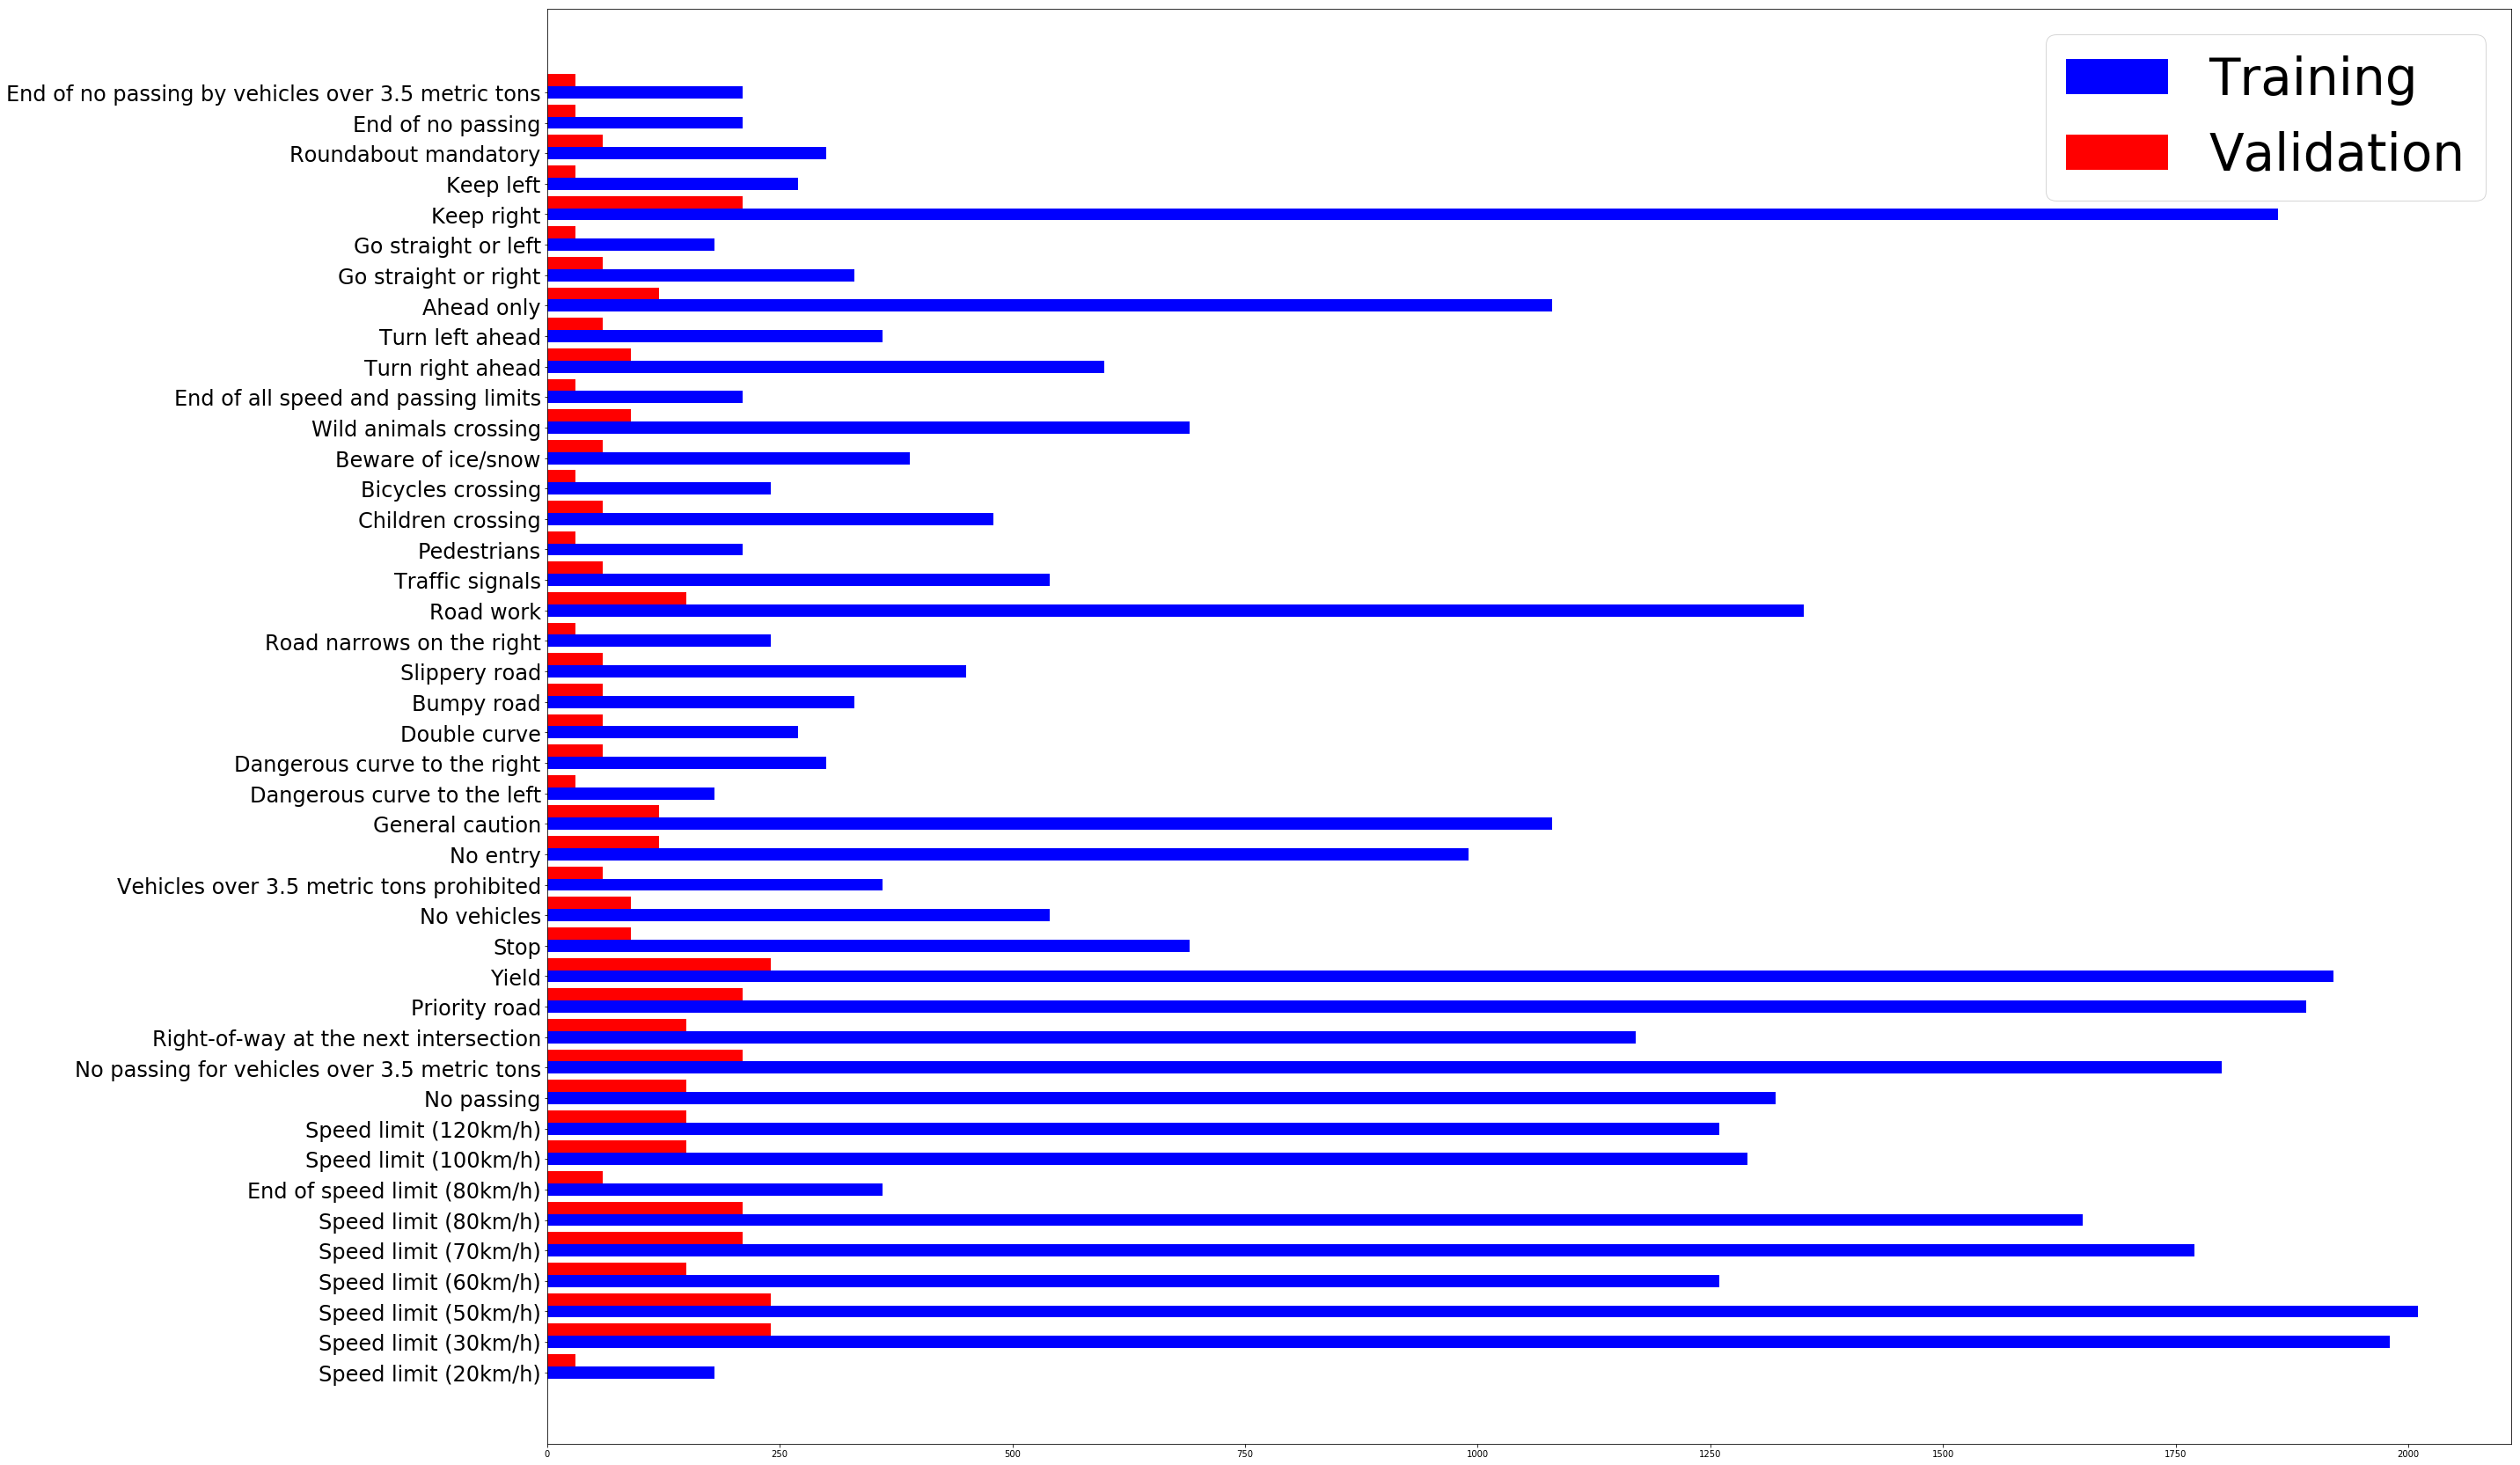

In [3]:
# Initialize data from the original given pickle files
X_train_orig, y_train_orig, X_train_size, X_train_coord,X_validation_orig, y_validation_orig,X_test_orig, y_test_orig =read_orig()
#Read the names of the signs and the associated label Id
df=pd.read_csv('signnames.csv',header=0,index_col=0)

summary(X_train_orig, y_train_orig, X_train_size, X_train_coord,X_validation_orig, y_validation_orig,X_test_orig, y_test_orig ,df)

In [4]:
def do_aug(input_file,temp_path,output_file,num_of_classes,num_samples):
    '''
    Function to do data augmentation using the Augmentor library.It creates 
    a pickle file of the augmented data.Images exist on disk in the temp_path folder.
    They can be deleted if required.
    '''
    temp_path="./"+temp_path
    output_file="./"+output_file
    i=0
    while i<num_of_classes:
        try:
            os.makedirs(temp_path+"/"+str(i))
        except:
            #delete folder and try creating again.
            shutil.rmtree(temp_path+"/"+str(i))
            print("Deleted existing folder",temp_path+"/"+str(i))
            i=i-1
        finally:
            i=i+1
    
    with open(input_file, mode='rb') as f:
        obj = pickle.load(f)
        X, y = obj['features'], obj['labels']
    for i in range(len(y)):
        plt.imshow(X[i])
        #Example aug_data/31/325.jpg (X[325] has label 31)
        plt.imsave(temp_path+"/"+str(y[i])+"/"+str(i)+".jpg", X[i])
    
    '''Augmentor requires a folder of images as input.'''
    # The data augmentation pipeline where you can sequentially add operations and their probability.
    for i in range(num_of_classes):
        # output folder of augmented data is the same as the input folder
        p=Augmentor.Pipeline(temp_path+"/"+str(i),".")
        p.rotate(probability=0.5,max_left_rotation=15,max_right_rotation=15)
        p.skew(0.5,0.5)
        #Creating num_samples  number of augmented images
        val=p.sample(num_samples)

    obj={}
    #Remove existing output pickle if any
    try:
        os.remove(output_file)
    except:
        print("No existing file.Continuing")
    for i in range(num_of_classes):
        #there is always an extra folder named "/0" created .Removing that
        os.rmdir(temp_path+"/"+str(i)+"/0")
        X=np.array([])
        y=[]
        for filename in os.listdir(temp_path+"/"+str(i)):
            y.append(i)
            image = cv2.imread(temp_path+"/"+str(i)+"/"+filename)
            #since cv2.imread reads in BGR and we work with RGB 
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h,w,c=image.shape
            image=image.reshape(1,h,w,c)
            if len(X)==0:
                X=image
            else:
                X=np.concatenate((X, image),axis=0)
        
        #######################################
        #To delete the augmented data folder uncomment the below line
        #shutil.rmtree(temp_path+"/"+str(i))
        #######################################
        
        #Write out pickled data for each class
        obj['features'] = X
        obj['labels'] = y
        #Open file in binary and append to it.
        with open(output_file,"ba+")as pfile:
            pickle.dump(obj,pfile,protocol=pickle.HIGHEST_PROTOCOL)
            print("dumped"+str(len(obj['features']))+" image's data")
    return
def read_aug(file):
    '''
    Returns augmented data and label
    Input:Pickle file containing augmented data
    Output:X(4d np array),y(1d np array)
    '''
    X=[]
    y=[]
    with open(file, mode='rb') as f:
            for i in range(43):
                train = pickle.load(f)
                if len(X)==0:
                    X=train['features']
                    y=train['labels']
                else:
                    X=np.concatenate((X,train['features']))
                    y=np.concatenate((y,train['labels']))            
    return X,y

### Exploratory visualization of the original dataset

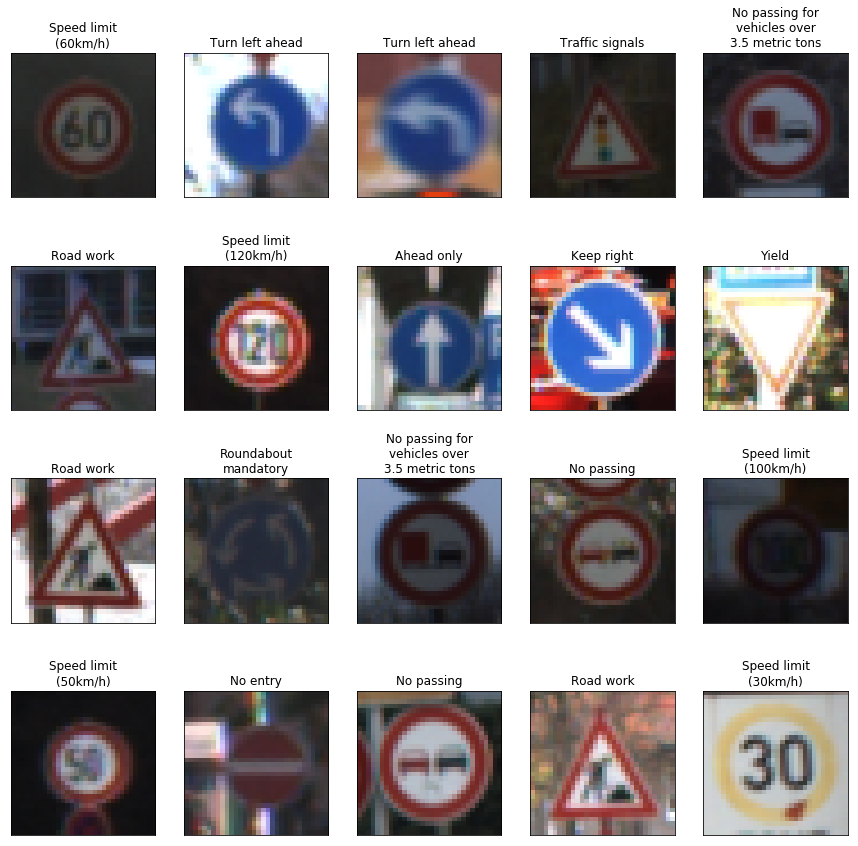

In [5]:
plt.figure(figsize=(15,15))
for i in range(20):
    ax=plt.subplot(4,5,i+1)
    j=randint(0,len(X_train_orig)-1)
    ax.set_title("\n".join(wrap(df['SignName'][int(y_train_orig[j])],15)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(X_train_orig[j])
plt.show()

### Perform Data Augmentation.
Since the augmented images are saved on disk.It needn't be run every single time.
Data Augmentation pipeline in this case is :
- p.rotate(probability=0.5,max_left_rotation=15,max_right_rotation=15)
- p.skew(0.5,0.5)

Rotation from -15 to 15 with a probability of 50% and then skew the image in a random direction by 0.5 with a probablity of 0.5
We then add 1000 images to each class.

In [6]:
# creates a new folder that contains the augmented images.It can be deleted if wanted by .Check do_aug()


#do_aug('traffic-signs-data/train.p','aug_data_train','traffic-signs-data/aug_train.p',43,1000)

### Read data from pickle file of augmented training data.

In [7]:
X_train_aug,y_train_aug=read_aug('traffic-signs-data/aug_train.p')

### Samples of all 43 traffic signs

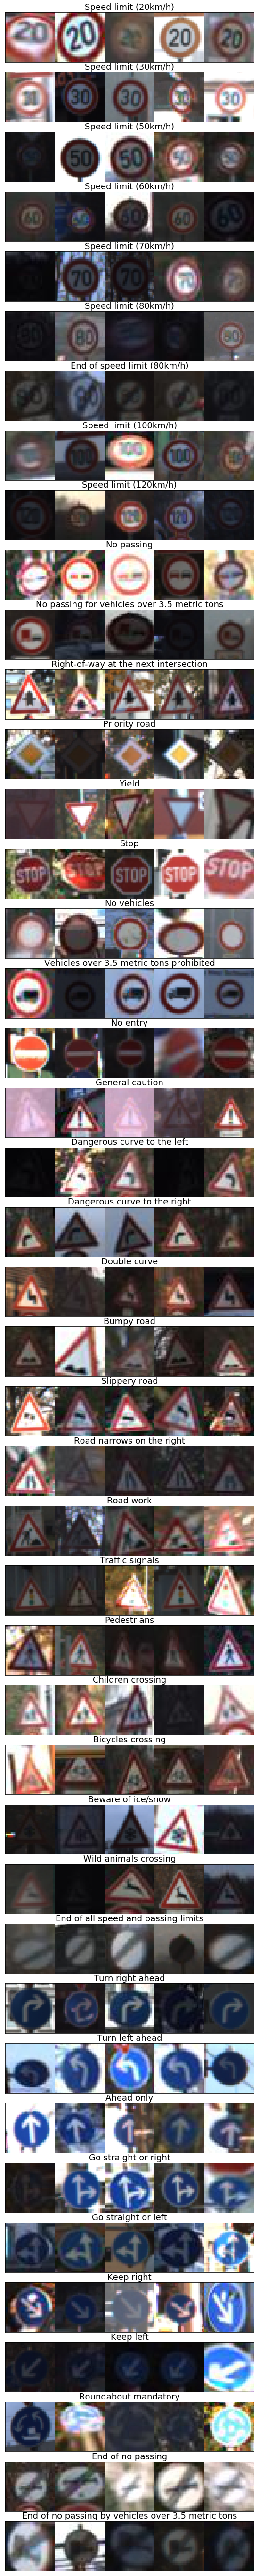

In [8]:
plt.figure(figsize=(15,100))
for i in range(43):
    files=os.listdir("aug_data_train"+"/"+str(i))
    index=sample(range(len(files)), 5)
    img=[]
    for file_index in index:
        image = cv2.imread("aug_data_train"+"/"+str(i)+"/"+files[file_index])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if len(img)==0:
            img=image
        else:
            img = np.append(img,image,axis=1)
    ax=plt.subplot(43,1,i+1)
    ax.set_title(df['SignName'][int(i)], fontsize=18)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img,cmap="gray")
plt.show()

### Functions used for data preprocessing

In [9]:
def histogram_equalisation(X):
    '''
    Given an RGB input it converts the image to YUV and then performs a  histogram equalisation of  the Y channel.
    Input is a 4d array
    Output is a 4d array
    '''
    # input X is 4d array so is the output
    temp_out=np.empty((len(X),default_h,default_w,X.shape[3]))
    out=np.empty((len(X),default_h,default_w,3))
    for i in range(len(X)):
        if (X.shape[1]!=32 or X.shape[2]!=32):
            temp_out[i]=cv2.resize(X[i],(32,32),interpolation=cv2.INTER_AREA).reshape(default_h,default_w,training_data_color)
            cv_img=temp_out[i].astype(np.uint8)
        else:
            temp_out[i]=X[i]
            cv_img=temp_out[i].astype(np.uint8)
        img_yuv=cv2.cvtColor(cv_img, cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # convert the YUV image back to RGB format
        out[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB )
        temp_out[i]=out[i].astype(np.uint8)
        #ensure its the correct dimension
        temp_out[i].resize(1,default_h,default_w,3)
    temp_out=temp_out.astype(np.uint8)
    return temp_out

def normalize_gray(image):
    '''
    Convert to grayscale and then normalize image to a value between alpha and beta i.e (0,1)
    '''
    norm_image=np.copy(image)
    norm_image=cv2.normalize((cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)), dst=norm_image,alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image
    
def pipeline(X,op):
    '''
    Always normalizes.Histogram equalization is optional
    Returns grayscale normalized image with an option for histogram equalisation
    '''
    if op=='hist':
        X=histogram_equalisation(X)
    train_image=np.array([normalize_gray(num) for num in X])
    n,h,w=train_image.shape
    X=train_image.reshape(n,h,w,1)
    return X 

In [10]:
X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

In [11]:
preprocess_flag='hist'
X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

### Show before and after of images after passing through the pipeline

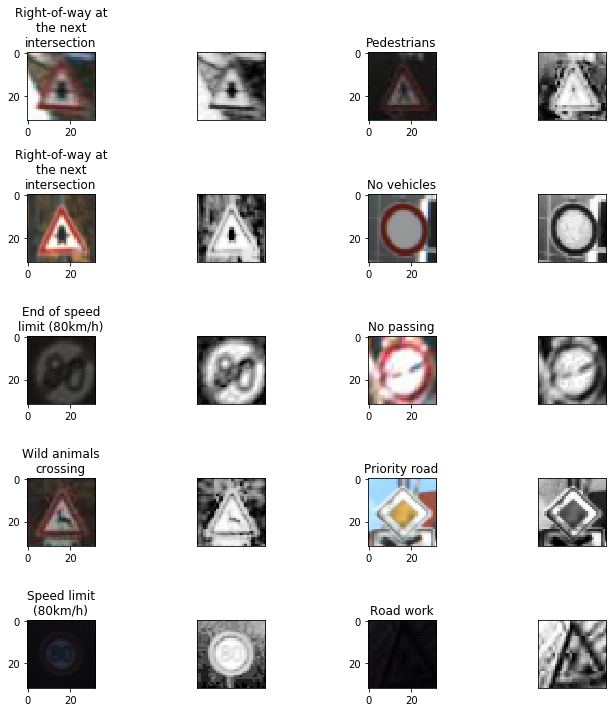

In [12]:
plt.figure(figsize=(10,10))
list=sample(range(len(X_train_aug)), 10)
num=1
for i in range(10):
    ax=plt.subplot(5,4,num)
    num=num+1
    j=list[i]
    ax.set_title("\n".join(wrap(df['SignName'][int(y_train_aug[j])],15)))
    ax.imshow(X_train_aug[j])
    ax=plt.subplot(5,4,num)
    plt.tight_layout()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(X_train[j].reshape(32,32),cmap='gray')
    num=num+1
plt.show()

### Functions for creating layers in the model  

In [13]:
def conv(input,filter_size,channel_in,channel_out,mu,sigma,stride,padding):
    weight = tf.Variable(tf.truncated_normal([filter_size, filter_size, channel_in, channel_out],mean=mu,stddev=sigma))
    bias = tf.Variable(tf.zeros(channel_out))
    conv_layer = tf.nn.conv2d(input, weight, strides=[1, stride, stride, 1], padding=padding)
    conv_layer = tf.nn.bias_add(conv_layer, bias)    
    conv_layer = tf.nn.relu(conv_layer)
    return conv_layer

def fc(flat_layer,mu,sigma,input_size,output_size):
    weight=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias = tf.Variable(tf.zeros(output_size))
    fc=tf.matmul(flat_layer,weight)+bias
    fc_layer=tf.nn.relu(fc)
    return fc_layer


### The convolutional network 

In [14]:
def cnn(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    global conv_layer1,conv_layer2,conv_layer3
    
    c_in=[1,24,48]
    c_out=[24,48,96]
    nsize=32
    L=0
    #conv(input,filter_size,channel_in,channel_out,mu,sigma,stride,padding)
    ARGS=[(x,5,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer1=conv(*ARGS[0])
    conv_layer1=tf.nn.max_pool(conv_layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=16
    L=L+1
    ARGS=[(conv_layer1,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer2=conv(*ARGS[0])
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=8
    
    L=L+1
    ARGS=[(conv_layer2,2,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer3=conv(*ARGS[0])
    conv_layer3=tf.nn.max_pool(conv_layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=4
    prev_layer=conv_layer3
    
    # Flatten.
    flat_layer = tf.contrib.layers.flatten(prev_layer)
    
    # Layer: Fully Connected. 
    input_size=nsize*nsize*c_out[L]
    output_size=768
    fc_layer1=fc(flat_layer,mu,sigma,input_size,output_size)
    dropout1=tf.nn.dropout(fc_layer1,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=332
    fc_layer2=fc(dropout1,mu,sigma,input_size,output_size)
    dropout2=tf.nn.dropout(fc_layer2,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=43
    
    weight5=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias5 = tf.Variable(tf.zeros(output_size))
    logits=tf.matmul(fc_layer2,weight5)+bias5    
    return logits

### Training and evaluation functions

In [15]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def softmax(X_data):
    values,indices=sess.run(tf.nn.top_k(logits, k=5),feed_dict={x:X_data,keep_prob: 1})
    return values,indices

def train(function,dropout_rate,EPOCHS,file= './lenet'):
    
    global accuracy_operation,correct_prediction,training_operation,optimizer,loss_operation
    global cross_entropy,logits,x,y,one_hot_y,rate,keep_prob
    global X_train,X_test,X_validation,y_train,y_test,y_validation
    global saver
    global sess
    global BATCH_SIZE
    
    X_train, y_train = shuffle(X_train, y_train)
    X_validation,y_validation=shuffle(X_validation,y_validation)
    X_test,y_test=shuffle(X_test,y_test)
    
    x = tf.placeholder(tf.float32, (None, 32, 32, 1),name="x_for_training")
    y = tf.placeholder(tf.int32, (None),name="y_for_Training")
    keep_prob=tf.placeholder(tf.float32,(None),name="dropout_percent")
    one_hot_y = tf.one_hot(y, 43)
    rate = 0.001
    
    logits = function(x,keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    
    ########
    #graph inputs
    v_error=[]
    t_error=[]
    x_axis=[]
    train_accuracy=0
    validation_accuracy=0
    ########
    
    print("{:10s}{:15s}{:15s}".format("EPOCH" ,"Train Accuracy","Validation Accuracy" ))
    for i in range(EPOCHS):
        train_accuracy=0
        count=0
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:dropout_rate})   
            train_accuracy=train_accuracy+evaluate(batch_x, batch_y)
            count=count+1
        train_accuracy=train_accuracy/count
        t_error=t_error+[1-train_accuracy]
        
        x_axis=x_axis+[i]
        
        validation_accuracy = evaluate(X_validation, y_validation)
        v_error=v_error+[1-validation_accuracy]
        print(" {:10s} {:15.3f}{:15.3f}".format(str(i+1),train_accuracy,validation_accuracy))    

    saver.save(sess, file)
    print("Model saved")
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    test_accuracy  = evaluate(X_test, y_test)
    train_accuracy = evaluate(X_train, y_train)
    validation_accuracy = evaluate(X_validation, y_validation)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    plt.figure(figsize=(5,5))
    plt.xticks(x_axis)
    plt.ylim(ymax=1,ymin=0)
    plt.plot(x_axis, v_error, '-ro',label='validation error')
    plt.plot(x_axis, t_error, '-bo',label='training error')
    plt.legend(loc='upper center', shadow=True)
    plt.show()

### Function to create output feature maps for a given layer

In [16]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    vis=[]
    activation = tf_activation.eval(session=sess,feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    for featuremap in range(featuremaps):
        img=activation[0,:,:, featuremap]
        img=cv2.resize(img,(20,20))
        if len(vis):
            vis = np.concatenate((vis, img),axis=1)
        else:
            vis=img
    return vis

def showfeature(X_myex_input,X_layer):
    plt.figure(figsize=(40,40))   
    num=len(os.listdir("myexamples/"))
    global conv_layer1
    count=0
    for i in range(X_myex_input.shape[0]):
        ax=plt.subplot(num,1,i+1)
        out=outputFeatureMap(X_myex_input[i:i+1],X_layer)
        for offset in range(0, out.shape[1], 480):
            end = offset + 480
            count=count+1
            if offset==0:
                image=out[:,offset:end]
            else:
                image=np.concatenate(( image,out[:,offset:end]),axis=0)
        plt.tight_layout()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(image,interpolation="nearest",cmap='gray')  
    plt.show() 

In [17]:
def myexamples(preprocess_flag):
    global saver
    global sess
    arr=[]
    X_myex=[]
    y_ex=[]
    num=1
    plt.figure(figsize=(15,15))
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    for filename in os.listdir("myexamples/"):
        arr=[]
        image = cv2.imread('myexamples/'+filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image= cv2.resize(image,(32,32))
        plt.figure(figsize=(15,15))
        plt.subplot(10,2,num)
        plt.imshow(image,interpolation="nearest", cmap="gray")
        
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        h,w,c=image.shape
        image.resize(1,h,w,c)
        out=pipeline(image,preprocess_flag)
        arr.append(out[0])
        X_myex.append(arr[0])
        arr=np.array(arr)
        values,indices =softmax(arr)
        e_x = np.exp(values - np.max(values))
        soft_out = e_x / e_x.sum()
        index=[]
        global df
        index=[df['SignName'][int(key)] for key in tuple(indices.tolist()[0])]
        plt.subplot(10,2,num+1)
        plt.xlim(0,1)
        input_x = np.arange(len(index))
        plt.yticks(input_x, index)
        plt.barh(input_x,soft_out.tolist()[0])    
    #for usage by showfeature
    X_myex=np.array(X_myex)
    return X_myex



### Train the model

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.499          0.765
 2                    0.864          0.918
 3                    0.938          0.951
 4                    0.962          0.960
 5                    0.974          0.960
 6                    0.980          0.966
 7                    0.986          0.968
 8                    0.988          0.971
 9                    0.991          0.973
 10                   0.992          0.970
Model saved
Train Accuracy = 0.990
Validation Accuracy = 0.970
Test Accuracy = 0.949


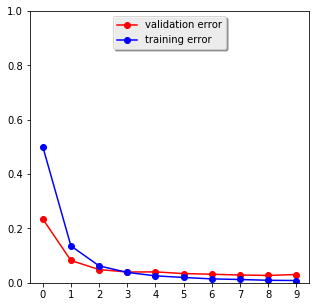

<IPython.core.display.Javascript object>

In [18]:
%%notify -m "1 done"
#Initialize appropriately

X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()


#Augmentation -YES
X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
#Preprocessing -YES
preprocess_flag='hist'
'''
model - CNN
Dropout- 0.2
EPOCHS- 10
'''
# Do data preprocessing 
X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)
# Train the function
train(function=cnn,dropout_rate=0.2,EPOCHS=10)

### Test with examples that I downloaded from the internet

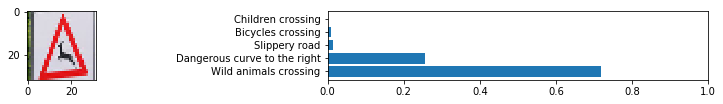

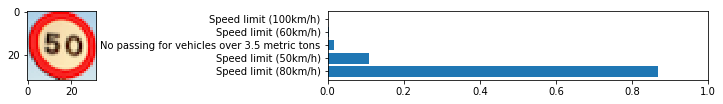

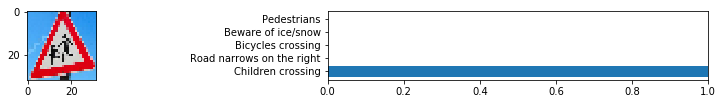

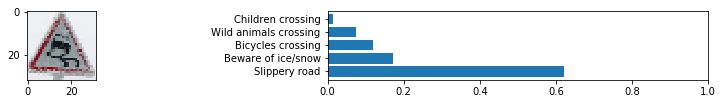

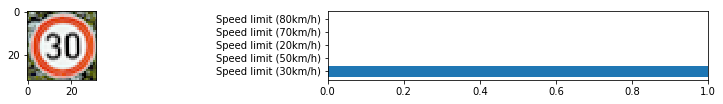

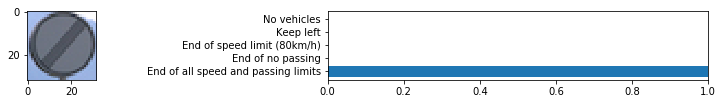

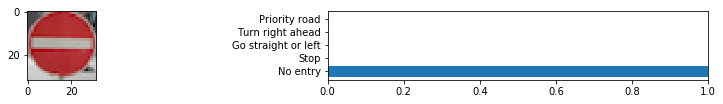

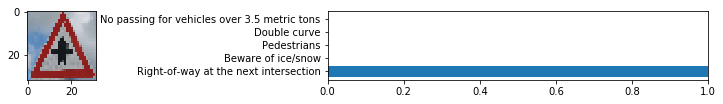

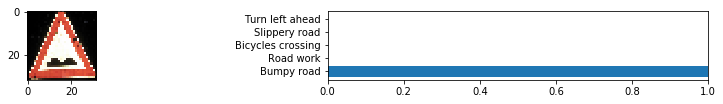

In [19]:
a=myexamples('hist')

### Show feature maps after convolution layer1

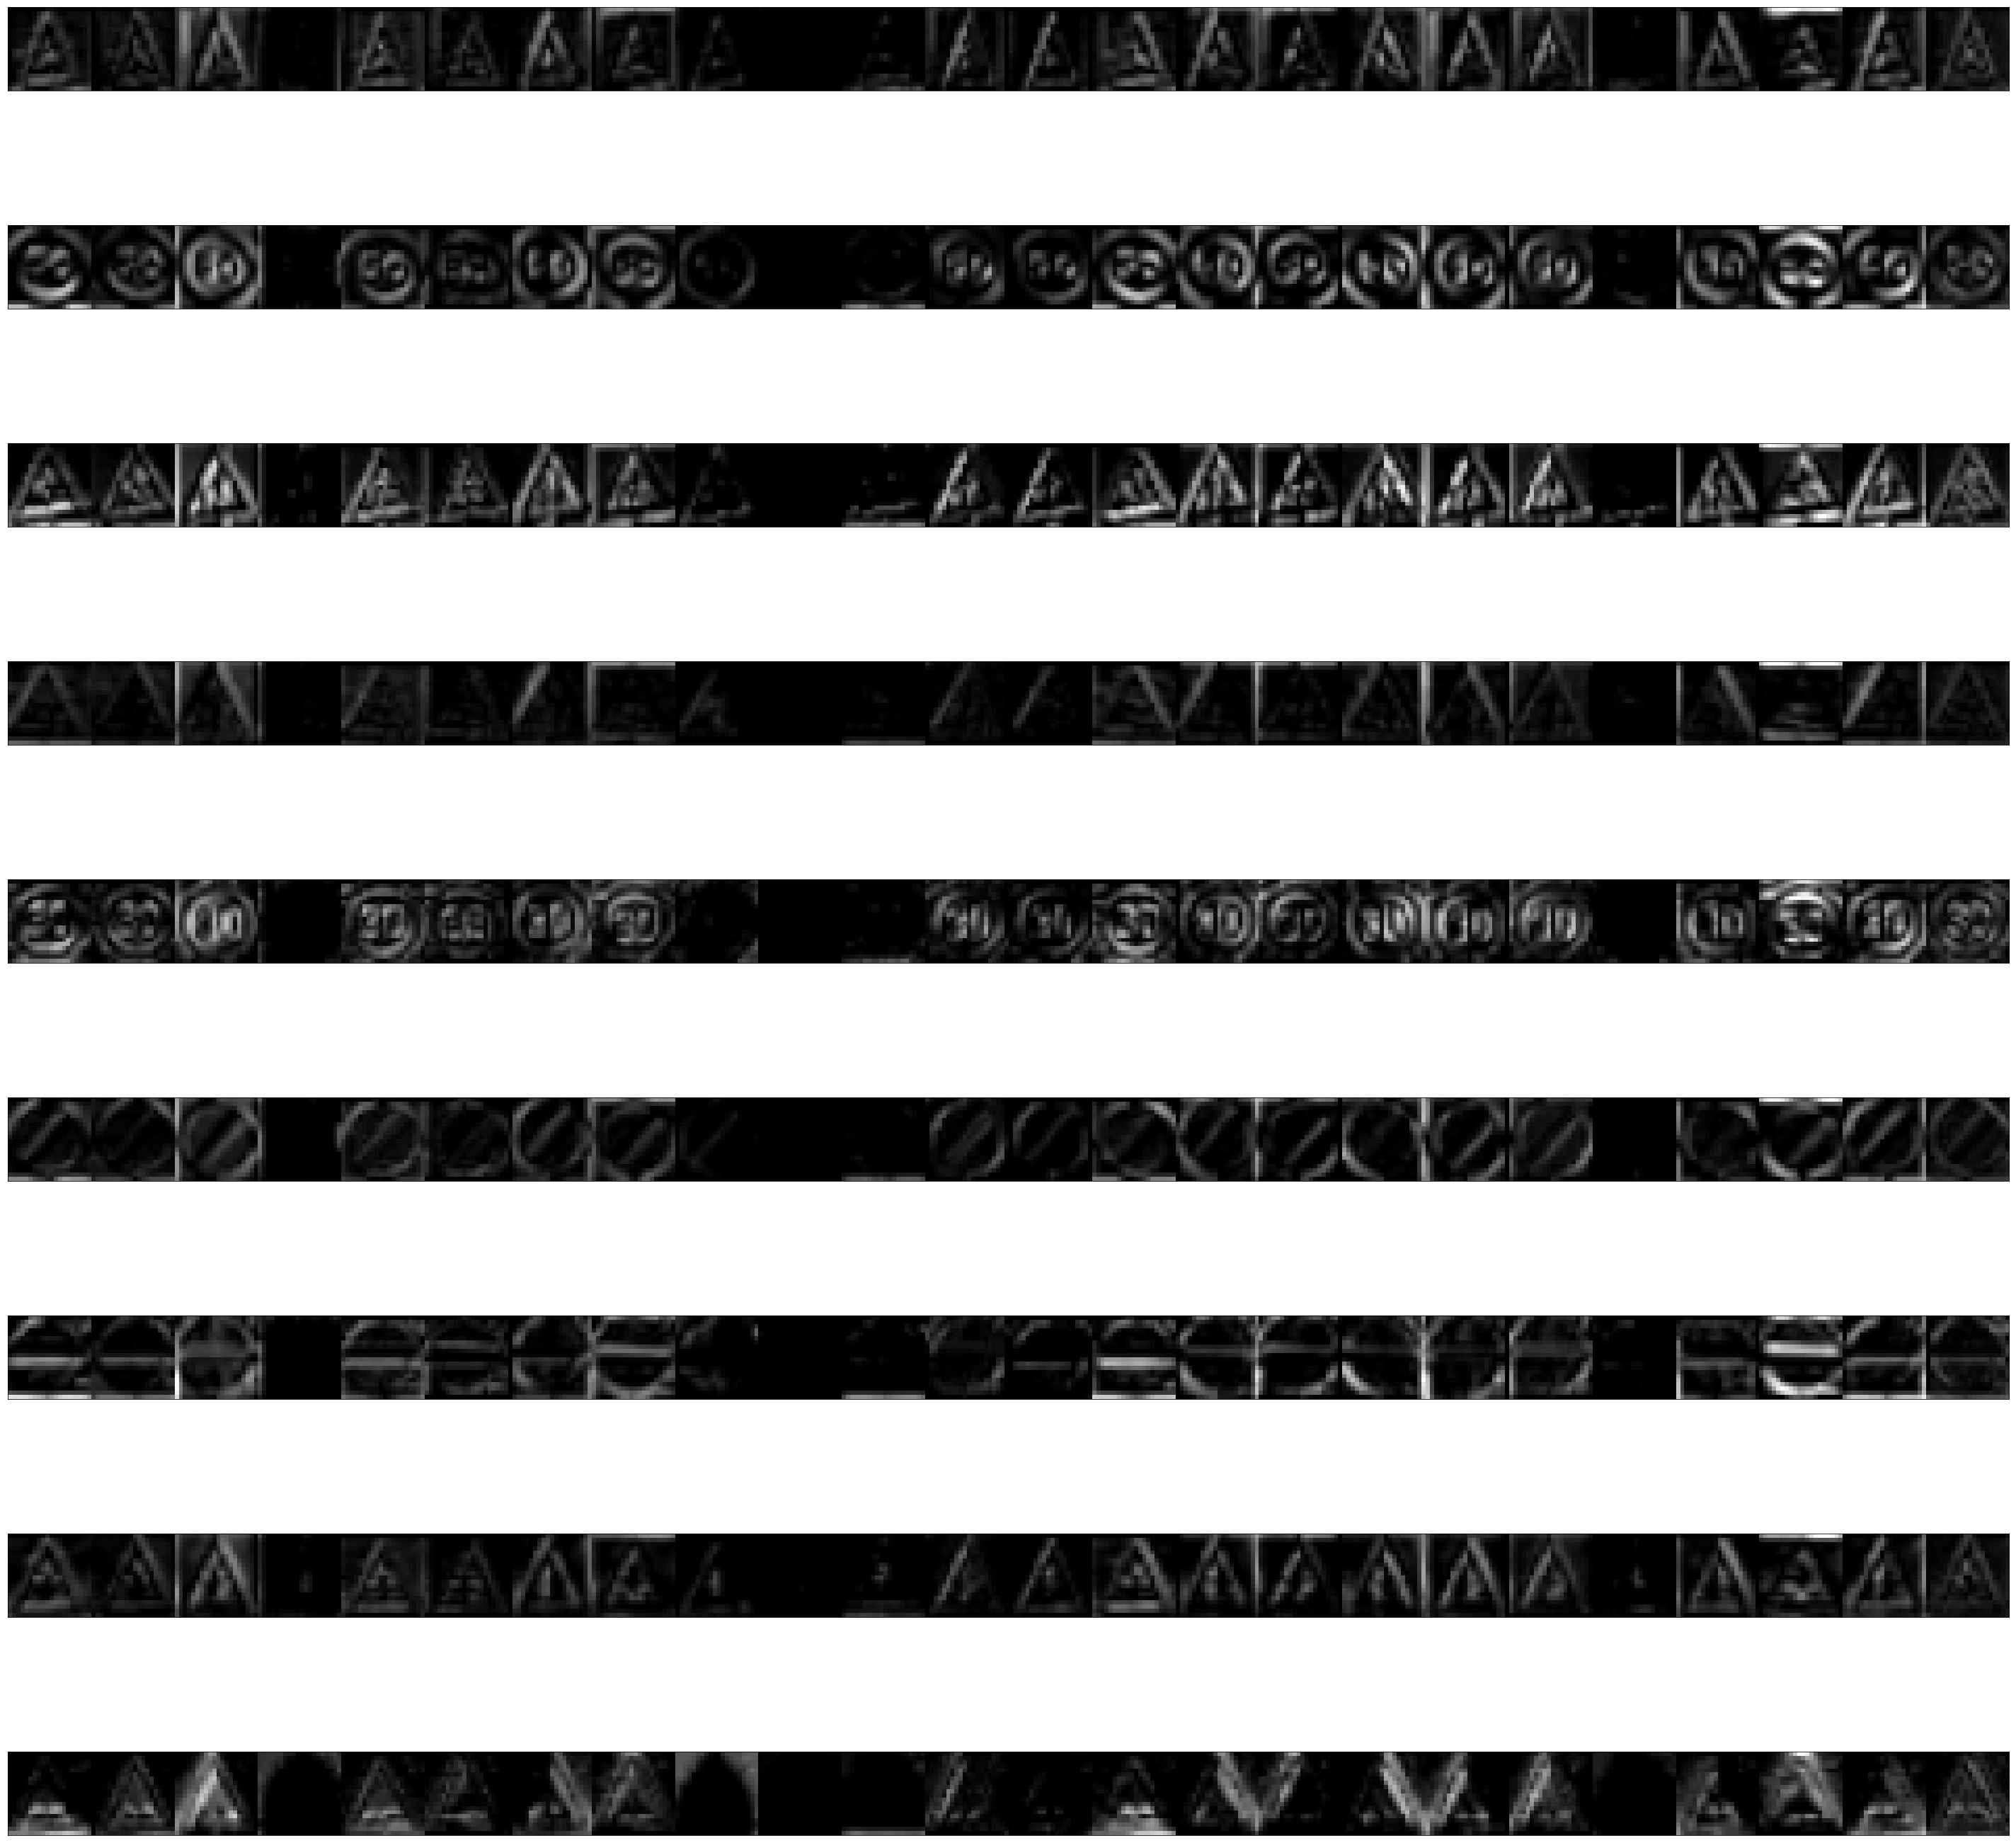

In [20]:
showfeature(a,conv_layer1)

### Show feature maps after convolution layer2

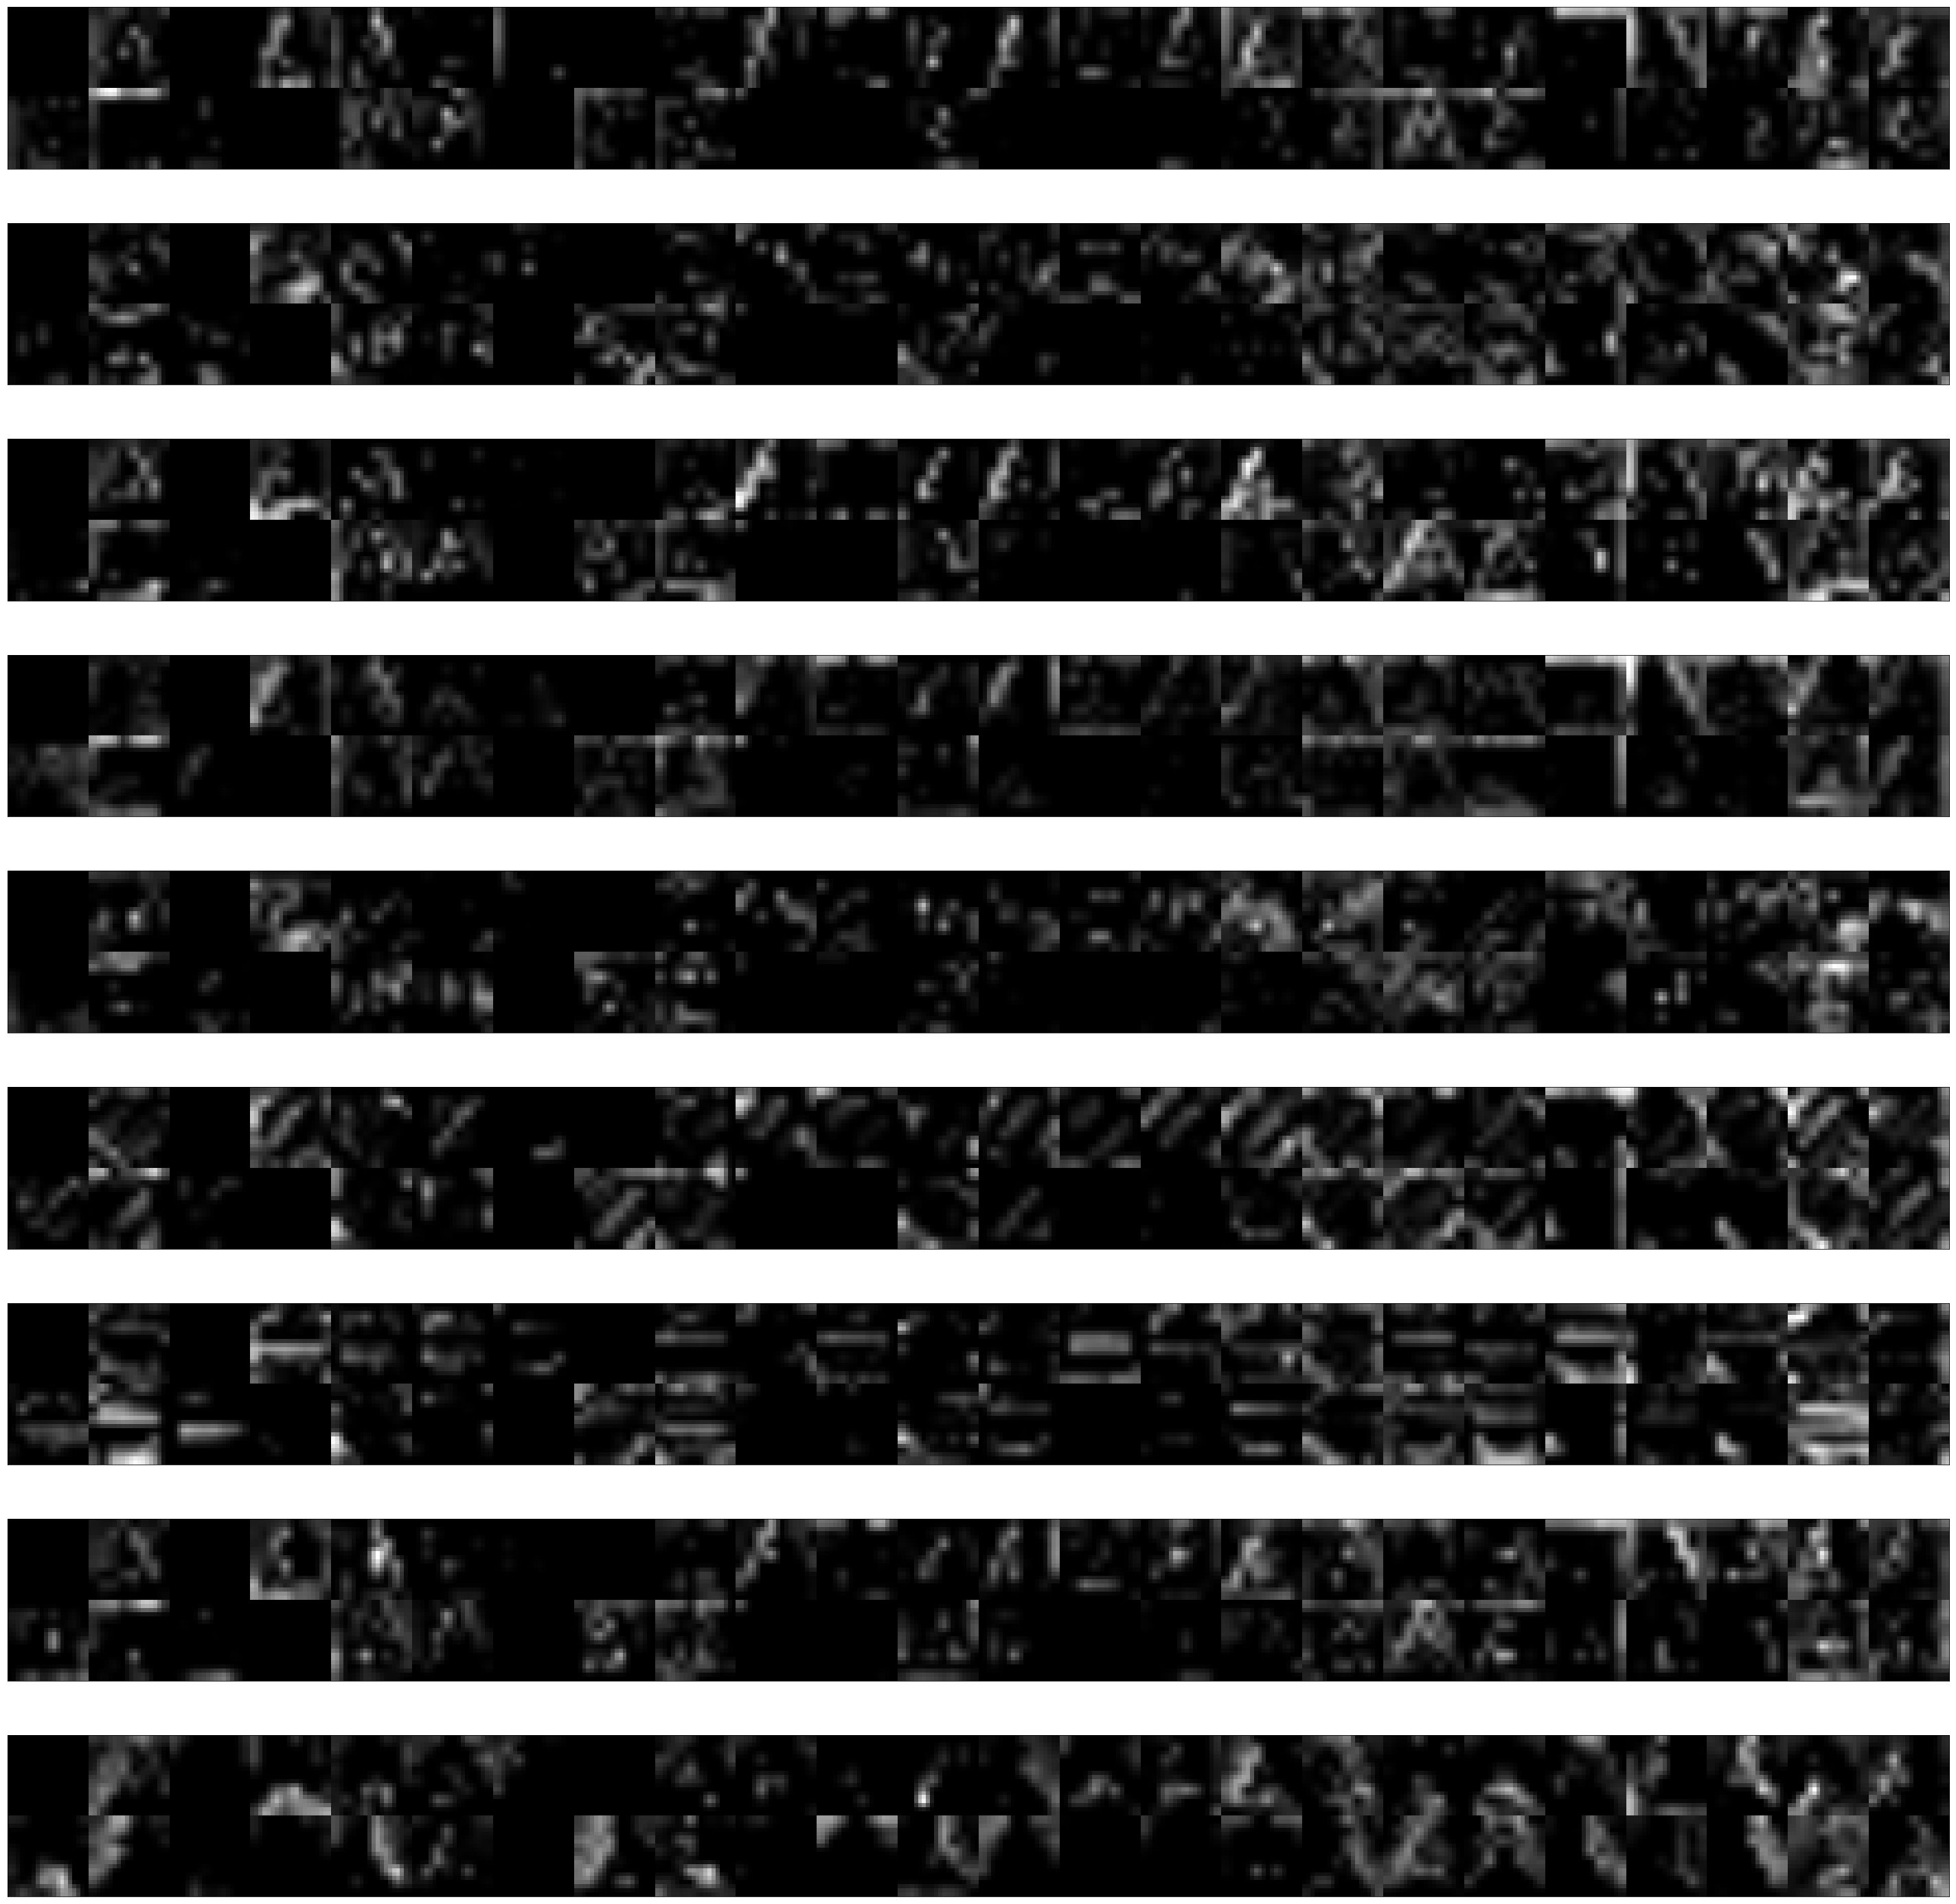

In [21]:
showfeature(a,conv_layer2)

### Show feature maps after convolution layer3

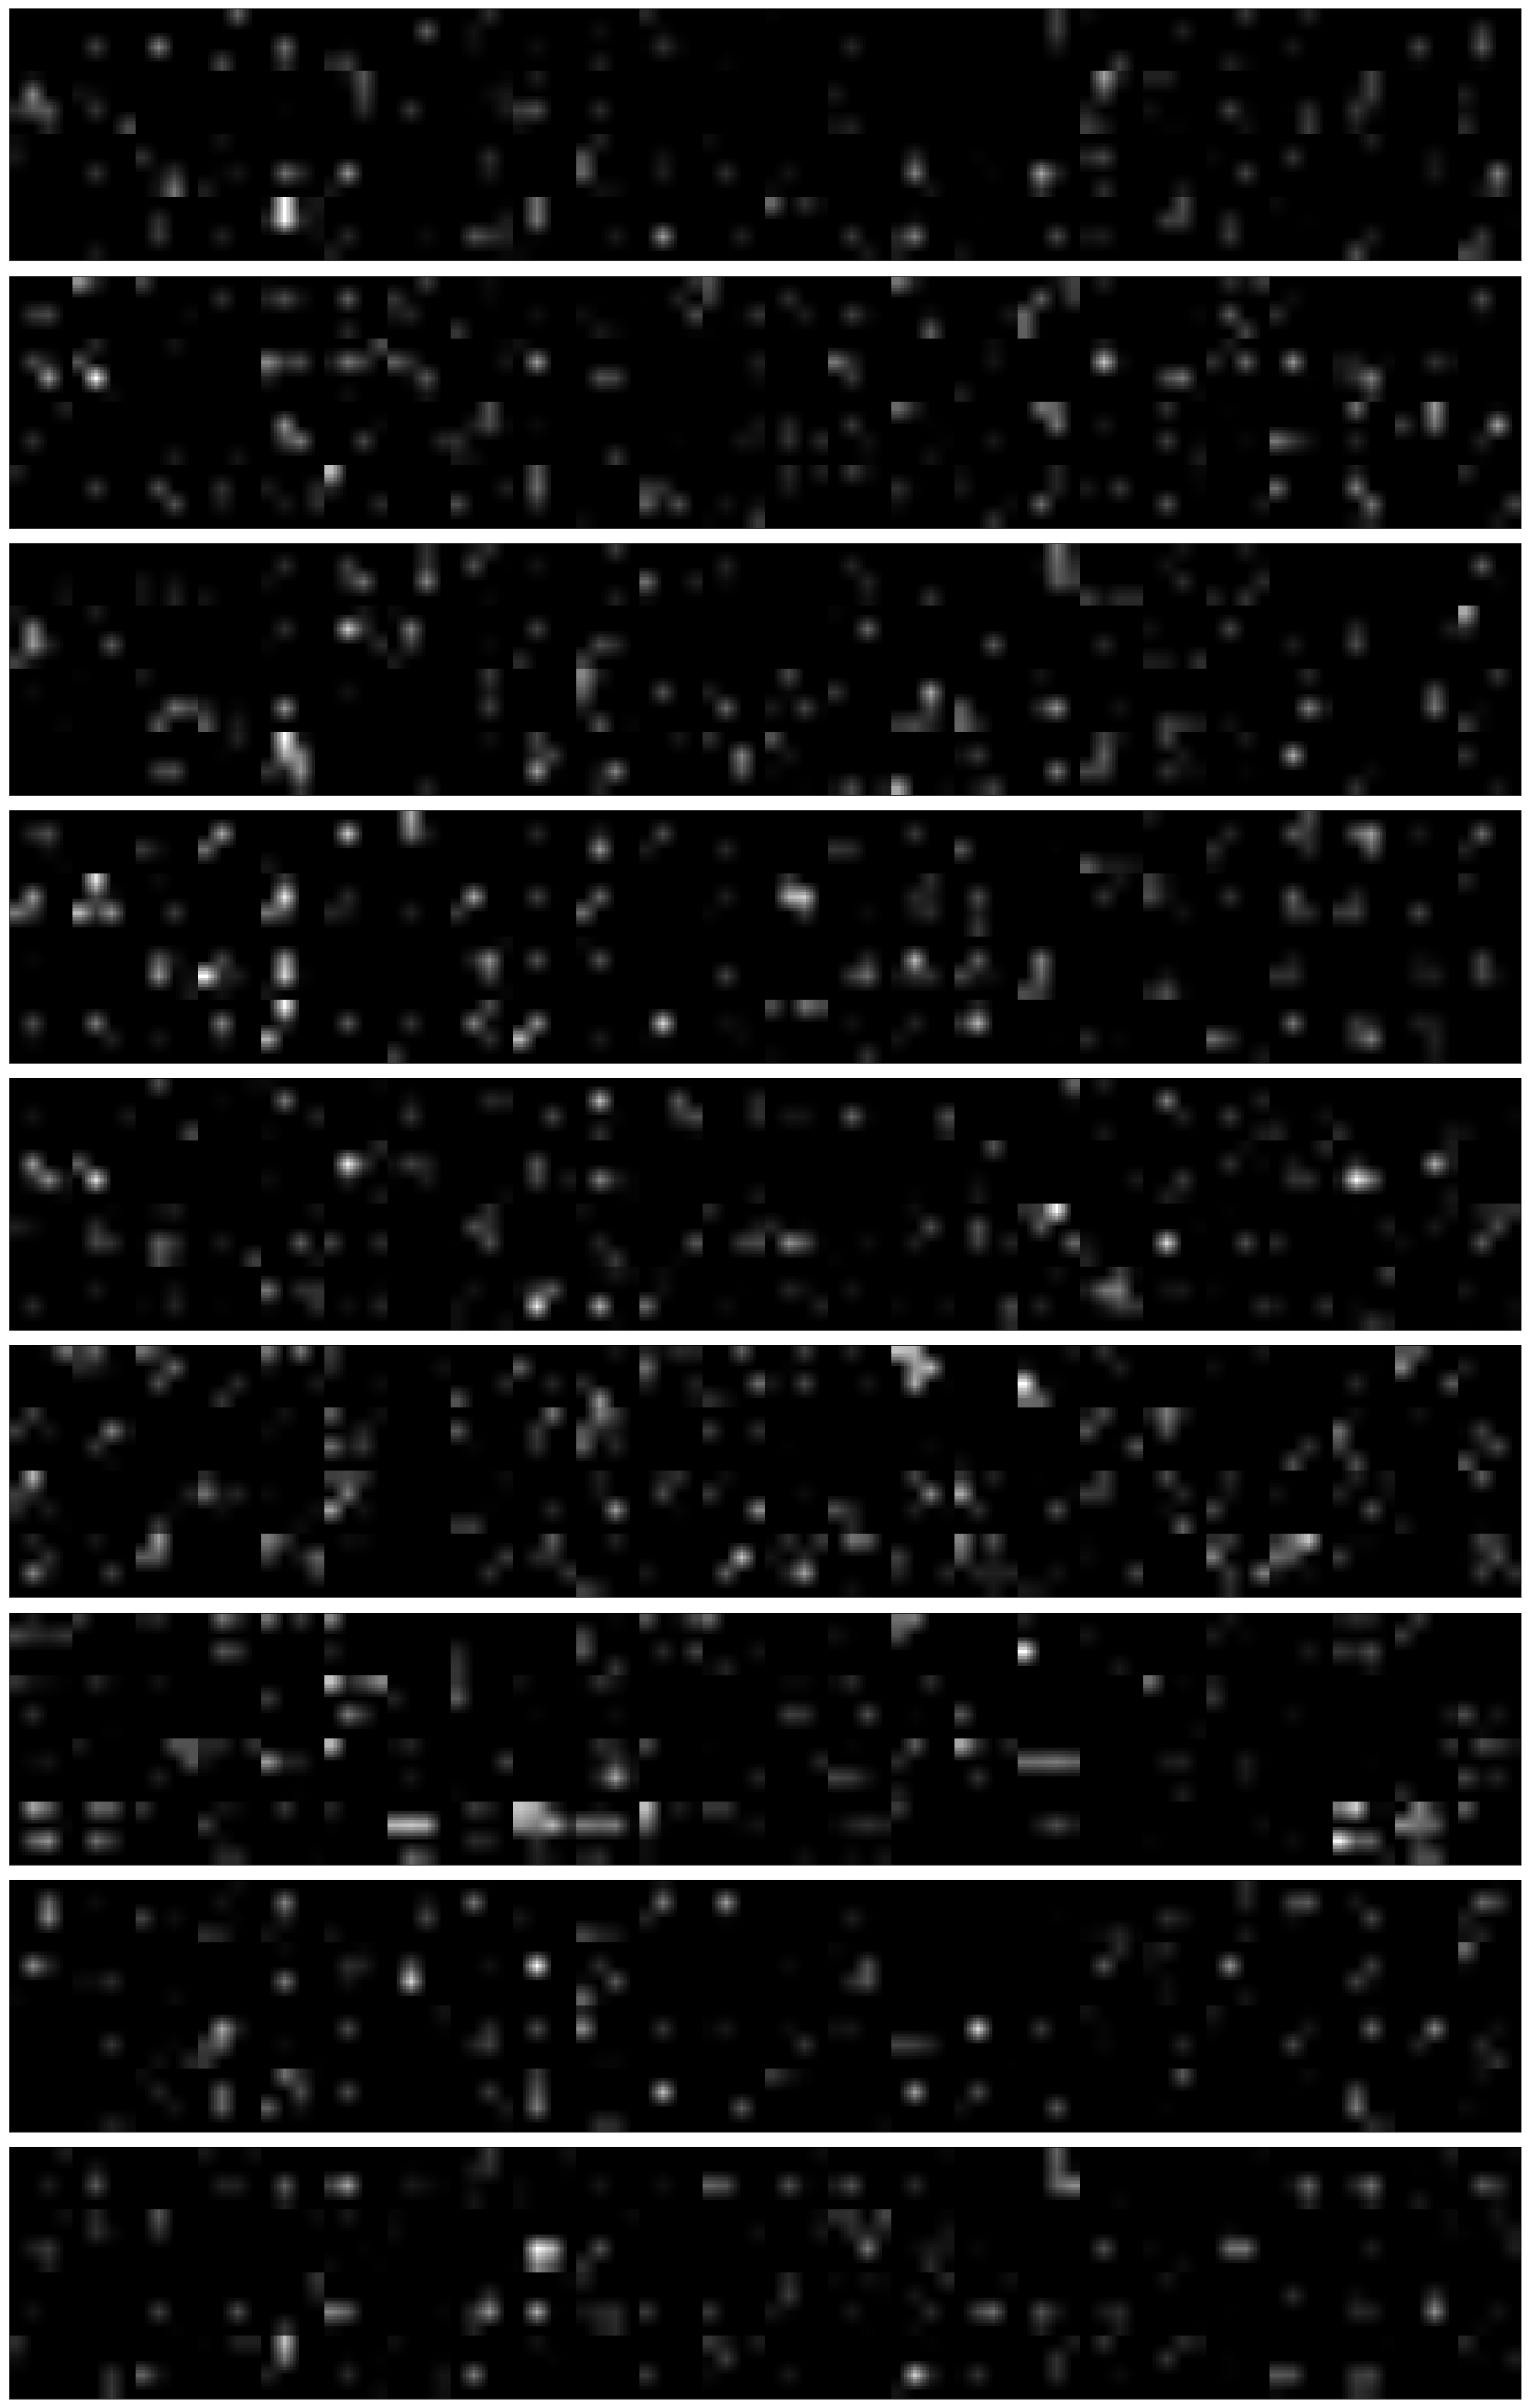

In [22]:
showfeature(a,conv_layer3)